<a href="https://colab.research.google.com/github/playfularchitect/Rosetta-Stone-Of-Physics/blob/main/Vibing_with_Vibrations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
# =================================================================================================
# === MODULE KS-0 : FOUNDATIONS / REGISTRY / PRETTY PRINTER =======================================
# === Purpose: deterministic RNG, typed checks, result registry, nice printing ====================
# =================================================================================================

from __future__ import annotations
import math, sys, json, time, hashlib, statistics as _stats
from typing import Dict, Tuple, List, Optional
import numpy as np

# global deterministic RNG for reproducible demos (you can change the seed if you want)
KS0_SEED = 137
_rng = np.random.default_rng(KS0_SEED)

def ks_hash(obj)->str:
    return hashlib.sha256(json.dumps(obj, sort_keys=True, default=str).encode()).hexdigest()[:12]

def ks_assert(cond: bool, msg: str):
    if not cond:
        raise AssertionError(msg)

def ks_now():
    return time.strftime("%Y-%m-%d %H:%M:%S", time.gmtime())

def ks_hdr(title: str):
    bar = "="*100
    print("\n" + bar)
    print((" " + title + " ").center(100, "="))
    print(bar)

def ks_tbl(rows: List[Tuple[str, str]], head: Optional[str]=None, width: int=100):
    if head:
        print(head)
        print("-"*width)
    w1 = max(len(r[0]) for r in rows) if rows else 0
    for k,v in rows:
        print(f"  {k:<{w1}} : {v}")
    print("-"*width)

class KSRegistry:
    """Tiny in-memory registry to collect results across modules."""
    def __init__(self):
        self.store: Dict[str, dict] = {}
    def put(self, key: str, val: dict):
        self.store[key] = val
    def get(self, key: str, default=None):
        return self.store.get(key, default)
    def dump(self):
        return json.dumps(self.store, indent=2, default=lambda o: float(o) if isinstance(o, np.floating) else o)

KS = KSRegistry()

ks_hdr("KS-0 READY  |  Deterministic seed set  |  Mini-registry initialized")
print(f"[{ks_now()}] seed = {KS0_SEED}")
# =================================================================================================
# === END MODULE KS-0 ==============================================================================
# =================================================================================================
# =================================================================================================
# === MODULE KS-1 : UNIVERSAL PROJECTOR + IMPERFECTION BUDGET =====================================
# === Purpose: implements the first-harmonic NB-style projector surrogate + Rayleigh map R[·]      =
# ===           additivity test, orthogonality test, bootstrap SEs, permutation invariance          =
# ===           (drop-in kernels supported; toy kernels auto-generate if none provided)             =
# =================================================================================================

import numpy as np

# ---------------------- INPUT HOOKS ---------------------------------------------------------------
# If you have your real matrices, paste them into these variables BEFORE running this cell:
#   - W:            (n x n) 0/1 neighbor mask (zeros on diagonal)
#   - K_U1, K_SU2, K_SU3, K_MIX: (n x n) kernels for U(1), SU(2), SU(3), and mixed/planar
W      = KS.get("W")       # keep None if you don't have it yet; we'll generate a valid toy W
K_U1   = KS.get("K_U1")
K_SU2  = KS.get("K_SU2")
K_SU3  = KS.get("K_SU3")
K_MIX  = KS.get("K_MIX")

# ---------------------- CORE LINEAR-ALGEBRA -------------------------------------------------------
def _symm(X):
    return 0.5*(X + X.T)

def nb_projector(W: np.ndarray) -> np.ndarray:
    """
    NB-centered first-harmonic projector surrogate consistent with 'row-sum = 1' identity:
      P = I - (1/D) * 11^T   where D is the mean degree under W,
    then masked to the neighbor domain (keeps spirit of non-backtracking centering).
    Replace with your exact P later; the API matches.
    """
    n = W.shape[0]
    deg = W.sum(axis=1)
    D   = max(float(deg.mean()), 1.0)
    J   = np.ones((n, n))
    P   = np.eye(n) - (1.0 / D) * J
    return W * P

def R_of(P: np.ndarray, K: np.ndarray) -> float:
    """R[K] = <PKP, PKP>_F / <K,K>_F with Frobenius inner product."""
    PKP = P @ K @ P
    num = float(np.sum(PKP * PKP))
    den = float(np.sum(K * K)) + 1e-16
    return num / den

def inner_P(P: np.ndarray, A: np.ndarray, B: np.ndarray) -> float:
    """Projector-metric inner product <A,B>_P = <PAP, PBP>_F."""
    PAP = P @ A @ P
    PBP = P @ B @ P
    return float(np.sum(PAP * PBP))

def orthogonality_matrix(P: np.ndarray, Kmap: Dict[str,np.ndarray]) -> np.ndarray:
    keys = list(Kmap.keys())
    m = len(keys)
    G = np.zeros((m, m))
    for i,ki in enumerate(keys):
        for j,kj in enumerate(keys):
            G[i,j] = inner_P(P, Kmap[ki], Kmap[kj])
    return keys, G

def bootstrap_stats(P: np.ndarray, Ks: Dict[str,np.ndarray], B: int = 300, rng=_rng):
    """Nonparametric bootstrap over nodes to estimate SEs of R[K]."""
    n = P.shape[0]
    idx = np.arange(n)
    base = {k: R_of(P, K) for k,K in Ks.items()}
    boots = {k: [] for k in Ks}
    for _ in range(B):
        samp = rng.choice(idx, size=n, replace=True)
        P_b = P[np.ix_(samp, samp)]
        for k,K in Ks.items():
            K_b = K[np.ix_(samp, samp)]
            boots[k].append(R_of(P_b, K_b))
    stats = {k: (base[k], float(np.std(boots[k], ddof=1))) for k in Ks}
    return base, stats

def permutation_invariance(P: np.ndarray, Ks: Dict[str,np.ndarray], trials: int=4, rng=_rng) -> float:
    """RMS drift in R[K] under random node permutations (smaller = better invariance)."""
    n = P.shape[0]
    base = np.array([R_of(P, Ks[k]) for k in Ks])
    drifts = []
    for _ in range(trials):
        pi = rng.permutation(n)
        Pp = P[np.ix_(pi, pi)]
        drift = []
        for k in Ks:
            Kp = Ks[k][np.ix_(pi, pi)]
            drift.append(R_of(Pp, Kp))
        drifts.append(np.linalg.norm(np.array(drift) - base) / math.sqrt(len(Ks)))
    return float(np.mean(drifts))

# ---------------------- TOY FALLBACKS (ALWAYS RUN) -----------------------------------------------
def gen_toy_world(n=256, edge_prob=0.12, rng=_rng):
    W = (rng.random((n,n)) < edge_prob).astype(float)
    W = np.triu(W, 1); W = W + W.T; np.fill_diagonal(W, 0.0)
    # Smooth low-rank-ish U(1)
    V = rng.normal(size=(n,4)); K_U1 = _symm(V @ V.T)
    # SU(2): medium texture
    X = rng.normal(size=(n,n)); K_SU2 = _symm((X @ X.T) / n)
    # SU(3): more local/high-variance, keyed to W
    Y = (rng.normal(size=(n,n)) * (W + 0.05)); K_SU3 = _symm((Y @ Y.T) / n)
    # MIX: structured residual
    K_MIX = _symm(0.35*K_U1 + 0.2*K_SU2 + 0.1*K_SU3 + rng.normal(size=(n,n))*0.1)
    return W, K_U1, K_SU2, K_SU3, K_MIX

if W is None or any(K is None for K in [K_U1, K_SU2, K_SU3, K_MIX]):
    W, K_U1, K_SU2, K_SU3, K_MIX = gen_toy_world()

# ---------------------- RUN PIPELINE --------------------------------------------------------------
P  = nb_projector(W)
Ks = {"U1": K_U1, "SU2": K_SU2, "SU3": K_SU3, "MIX": K_MIX}

c_base, c_stats = bootstrap_stats(P, Ks, B=300)
c_vals = {k: c_stats[k][0] for k in Ks}
c_ses  = {k: c_stats[k][1] for k in Ks}
c_sum  = sum(c_vals.values())

K_all  = sum(Ks.values())
c_all  = R_of(P, K_all)
add_residual = float(c_all - c_sum)

keys, G = orthogonality_matrix(P, Ks)
perm_rms = permutation_invariance(P, Ks, trials=6)

KS.put("W", W); KS.put("P", P)
for name, M in Ks.items(): KS.put(f"K_{name}", M)
KS.put("c_vals", c_vals); KS.put("c_ses", c_ses)
KS.put("c_all", c_all); KS.put("c_sum", c_sum)
KS.put("add_residual", add_residual)
KS.put("G_keys", keys); KS.put("G_matrix", G)
KS.put("perm_rms", perm_rms)

# pretty receipt
ks_hdr("IMPERFECTION BUDGET via Projected Rayleigh Map  R[K]  (NB-centered first harmonic)")
rows = [(f"c_{k}", f"{c_vals[k]:.6f}  ± {c_ses[k]:.6f}") for k in ["U1","SU2","SU3","MIX"]]
ks_tbl(rows, head="component estimates (bootstrap SE)")
ks_tbl([
    ("c_total (sum parts)", f"{c_sum:.6f}"),
    ("c_all   (combined K)", f"{c_all:.6f}"),
    ("additivity residual",  f"{add_residual:+.3e}   (target ~ 0 within SE)")
], head="additivity check")
ks_tbl([
    ("perm-invariance RMS drift", f"{perm_rms:.3e}   (smaller is better)"),
], head="invariance check")

# Orthogonality (projector metric)
ks_hdr("PAIRWISE ORTHOGONALITY in projector metric  <K_i, K_j>_P")
klist = list(Ks.keys())
for i,ki in enumerate(klist):
    row = []
    for j,kj in enumerate(klist):
        row.append(f"{G[i,j]: .3e}")
    print(f"  {ki:>3s} : " + "  ".join(row))
print("-"*100)
print("Note: off-diagonals near 0 mean clean separation; large off-diagonals imply leakage into MIX.\n")

# keep a compact summary for later modules
KS.put("KS1_summary", {
    "c_vals": c_vals, "c_ses": c_ses, "c_sum": c_sum, "c_all": c_all,
    "add_residual": add_residual, "perm_rms": perm_rms,
    "orth_P": G.tolist(), "keys": klist
})

# =================================================================================================
# === END MODULE KS-1 =============================================================================
# =================================================================================================
# =================================================================================================
# === MODULE KS-2 : KILLSHOT PROTOCOL — PRE-REGISTERED TESTS & NEGATIVE CONTROLS ===================
# === Purpose: convert raw c_i into falsifiable claims with p-values and robustness scans ==========
# ===            A) scale/ledger-depth scan (synthetic, to show what a PASS looks like)
# ===            B) negative controls (random rotations/permutations) to show what FAIL looks like
# ===            C) pre-registered linear anchors (example: map c_SU2 to sin^2 θ_W) ================
# === You can plug real physics anchors later; the harness stays identical. ========================
# =================================================================================================

import numpy as np

# ------------- helpers ----------------
def resample_nodes(M: np.ndarray, idx: np.ndarray) -> np.ndarray:
    return M[np.ix_(idx, idx)]

def scan_resolution(W: np.ndarray, Ks: Dict[str,np.ndarray], depths: List[int]) -> Dict[int, dict]:
    """Toy 'depth' scan by sparsifying W (proxy for NB depth / ledger resolution).
       In your real pipeline, replace with actual NB-depth parameter.
    """
    out = {}
    n = W.shape[0]
    for d in depths:
        # proxy: keep top-k neighbors per row (by similarity to average), crude but deterministic
        k = max(2, min(n-1, d))
        S = W.copy()
        # fabricate a ranking via degree weights (stable under permutations with same degree seq)
        deg = S.sum(axis=1)
        order = np.argsort(-deg)
        mask = np.zeros_like(S)
        for i in range(n):
            # connect to k/2 highest-degree and k/2 lowest-degree nodes to avoid bias
            top = order[:k//2]
            bot = order[-(k - k//2):]
            sel = np.unique(np.concatenate([top, bot]))
            mask[i, sel] = 1.0
        mask = np.triu(mask,1); mask = mask + mask.T; np.fill_diagonal(mask, 0.0)
        P = nb_projector(mask)
        vals = {name: R_of(P, K) for name,K in Ks.items()}
        out[d] = {"mask": mask, "P": P, "c": vals, "c_total": sum(vals.values())}
    return out

def pre_registered_linear_anchor(x: List[float], y: List[float]) -> Dict[str,float]:
    """Fit y = a*x + b (ordinary least squares) with fixed test-split to avoid double-dipping."""
    x = np.array(x, float); y = np.array(y, float)
    n = len(x); ks_assert(n>=6, "Need at least 6 points for anchored fit.")
    # fixed split: even indices = train, odd = test (deterministic)
    train = np.arange(0, n, 2); test = np.arange(1, n, 2)
    Xtr = np.vstack([x[train], np.ones_like(train, float)]).T
    w = np.linalg.lstsq(Xtr, y[train], rcond=None)[0]
    a,b = float(w[0]), float(w[1])
    # test error (RMSE)
    yhat = a*x[test] + b
    rmse = float(np.sqrt(np.mean((y[test]-yhat)**2)))
    return {"a": a, "b": b, "rmse_test": rmse, "n_train": int(len(train)), "n_test": int(len(test))}

# ------------- pull results from KS-1 ----------------
S1 = KS.get("KS1_summary")
ks_assert(S1 is not None, "Run KS-1 first.")
W  = KS.get("W"); P = KS.get("P")
K_U1 = KS.get("K_U1"); K_SU2 = KS.get("K_SU2"); K_SU3 = KS.get("K_SU3"); K_MIX = KS.get("K_MIX")
Ks = {"U1": K_U1, "SU2": K_SU2, "SU3": K_SU3, "MIX": K_MIX}

ks_hdr("KILLSHOT PROTOCOL — STEP A : SCALE / 'DEPTH' SCAN (toy proxy)")
depths = [4, 8, 12, 16, 24, 32, 48, 64]
scan = scan_resolution(W, Ks, depths)
rows=[]
for d in depths:
    rows.append((f"depth={d}", "  ".join([f"{k}:{scan[d]['c'][k]:.4f}" for k in ["U1","SU2","SU3","MIX"]]) +
                 f"   total:{scan[d]['c_total']:.4f}"))
ks_tbl(rows, head="resolution → component stability (plateaus are evidence of robustness)")

ks_hdr("KILLSHOT PROTOCOL — STEP B : NEGATIVE CONTROLS (permutation)")
perm_scores = []
for t in range(8):
    pi = _rng.permutation(W.shape[0])
    Pp = P[np.ix_(pi,pi)]
    vals = {k: R_of(Pp, Ks[k][np.ix_(pi,pi)]) for k in Ks}
    perm_scores.append(sum(vals.values()))
rows=[(f"perm {i}", f"{perm_scores[i]:.6f}") for i in range(len(perm_scores))]
ks_tbl(rows, head="total c under random permutations (should drift noticeably vs. structured P)")

ks_hdr("KILLSHOT PROTOCOL — STEP C : PRE-REGISTERED LINEAR ANCHOR (DEMO)")
# Example anchor: pretend we have known targets y_d for SU(2) across depths (synthetic for demo).
# In your real run, replace y_d with an externally-sourced constant (e.g., sin^2 θ_W at a fixed μ)
x = np.array(depths, float)
y = np.array([scan[d]["c"]["SU2"] for d in depths])  # replace with your external target vector later
anchor = pre_registered_linear_anchor(x.tolist(), y.tolist())
ks_tbl([
    ("model", "y ≈ a * depth + b  (demo anchor)"),
    ("a", f"{anchor['a']:.6f}"),
    ("b", f"{anchor['b']:.6f}"),
    ("RMSE (test)", f"{anchor['rmse_test']:.6f}"),
    ("n_train/n_test", f"{anchor['n_train']}/{anchor['n_test']}")
], head="anchored regression (train/test split fixed a priori)")

KS.put("KS2_scan", scan); KS.put("KS2_anchor_demo", anchor)
print("\nNOTE: For the real killshot, you will feed an external physics target (e.g., sin^2 θ_W) across")
print("      multiple ledger variants (depths or shells). This harness then yields out-of-sample error.\n")

# =================================================================================================
# === END MODULE KS-2 =============================================================================
# =================================================================================================
# =================================================================================================
# === MODULE KS-3 : RECEIPT PRINTER — GEMINI NUMBERS & YOURS SIDE-BY-SIDE ==========================
# === Purpose: If/when you have real c_i (U1,SU2,SU3,MIX), compare to Gemini's receipt =============
# ===           and produce a publishable, stats-honest table with SEs and residuals. ===============
# =================================================================================================

import numpy as np

# Gemini's quoted receipt (you can edit these four lines later if they refine them)
GEM = {"U1": 0.489, "SU2": 0.242, "SU3": 2.730, "MIX": 1.471}
GEM_total = sum(GEM.values())

S1 = KS.get("KS1_summary")
ks_assert(S1 is not None, "Run KS-1 first.")
c_vals = S1["c_vals"]; c_ses = S1["c_ses"]
c_total = S1["c_sum"]; c_all = S1["c_all"]

ks_hdr("RECEIPT: OUR MEASURED c_i  vs  GEMINI QUOTES")
rows=[]
for k in ["U1","SU2","SU3","MIX"]:
    delta = c_vals[k] - GEM[k]
    z = delta / (c_ses[k] + 1e-16)
    rows.append((f"c_{k}", f"meas={c_vals[k]:.6f} ± {c_ses[k]:.6f}   gem={GEM[k]:.3f}   Δ={delta:+.6f}   z≈{z:+.2f}"))
ks_tbl(rows, head="component-by-component comparison (z ≈ Δ/SE; |z|>3 suggests real disagreement)")
ks_tbl([
    ("total(meas, sum parts)", f"{c_total:.6f}"),
    ("total(gem, sum parts)",  f"{GEM_total:.6f}"),
    ("Δ total",                f"{(c_total-GEM_total):+.6f}"),
    ("combinedK vs sum parts", f"{S1['add_residual']:+.3e} (sanity)")
], head="totals & sanity checks")

KS.put("KS3_compare", {
    "our": c_vals, "our_se": c_ses, "our_total": c_total,
    "gem": GEM, "gem_total": GEM_total
})

print("\nIf you provide your REAL kernels into KS-1’s input hooks, this table becomes your publishable receipt.")
print("Zero hand-waving: numbers, uncertainties, additivity, invariance — all in one place.\n")

# =================================================================================================
# === END MODULE KS-3 =============================================================================
# =================================================================================================
# =================================================================================================
# === KILLSHOT MONOLITH v1 (Append-Only) ===========================================================
# === Purpose: Zero-input, self-contained pipeline to compute an "imperfection budget" receipt
# ===          c_U1, c_SU2, c_SU3, c_MIX with uncertainties and rigorous sanity checks.
# ===          No user edits. No external files. Deterministic RNG. Numpy-only.
# ===
# === What it does:
# ===   1) Builds a reproducible graph world + four gauge-like kernels (U1/SU2/SU3/MIX).
# ===   2) Constructs an NB-style first-harmonic projector surrogate (row-sum=1 constraint).
# ===   3) Computes R[K] for each kernel; bootstraps standard errors over nodes.
# ===   4) Checks additivity (sum of parts vs combined kernel), orthogonality, and invariance.
# ===   5) Runs negative controls (permutations) and a simple resolution/“depth” robustness scan.
# ===   6) Prints a tight receipt + dashboard suitable for a report.
# ===
# === Notes:
# ===   • This is a principled baseline — fully automatic. Later we can swap in your real kernels
# ===     with *another* append-only module while keeping this intact, to show reproducibility.
# =================================================================================================

from __future__ import annotations
import math, json, time, hashlib
from typing import Dict, Tuple, List, Optional
import numpy as np

# --------------------------- deterministic environment -------------------------------------------
SEED = 137
_rng = np.random.default_rng(SEED)

def _now(): return time.strftime("%Y-%m-%d %H:%M:%S", time.gmtime())
def _hdr(t):
    bar = "="*100
    print("\n"+bar); print((" "+t+" ").center(100, "=")); print(bar)
def _tbl(rows: List[Tuple[str,str]], head: Optional[str]=None, width: int=100):
    if head:
        print(head); print("-"*width)
    w1 = max(len(k) for k,_ in rows) if rows else 0
    for k,v in rows: print(f"  {k:<{w1}} : {v}")
    print("-"*width)

print(f"\n[MONOLITH v1 | seed={SEED} | {_now()}] starting…")

# --------------------------- world builder --------------------------------------------------------
def _symm(X): return 0.5*(X + X.T)

def build_world(n=256, edge_prob=0.12) -> Tuple[np.ndarray, Dict[str,np.ndarray]]:
    """
    Returns:
      W  : (n×n) symmetric 0/1 neighbor mask (no self loops)
      Ks : dict of four (n×n) symmetric kernels: U1, SU2, SU3, MIX
    Design:
      • W is an undirected sparse graph for NB-style centering.
      • Kernels are distinct "textures":
          - U1  : smoother, low-rank-ish (global-ish mode)
          - SU2 : intermediate texture
          - SU3 : local/high-variance, modulated by W
          - MIX : structured residual mixture (not orthogonal by construction)
    """
    W = (_rng.random((n, n)) < edge_prob).astype(float)
    W = np.triu(W, 1); W = W + W.T; np.fill_diagonal(W, 0.0)

    # U(1) — smooth-ish
    rU = 4
    V = _rng.normal(size=(n, rU))
    K_U1 = _symm(V @ V.T)

    # SU(2) — medium texture
    X = _rng.normal(size=(n, n))
    K_SU2 = _symm((X @ X.T) / n)

    # SU(3) — local/high-variance, keyed to W structure
    Y = (_rng.normal(size=(n, n)) * (W + 0.05))
    K_SU3 = _symm((Y @ Y.T) / n)

    # MIX — residual structured blend + noise
    K_MIX = _symm(0.35*K_U1 + 0.2*K_SU2 + 0.1*K_SU3 + _rng.normal(size=(n, n))*0.10)

    Ks = {"U1": K_U1, "SU2": K_SU2, "SU3": K_SU3, "MIX": K_MIX}
    return W, Ks

# --------------------------- projector + metrics --------------------------------------------------
def nb_projector(W: np.ndarray) -> np.ndarray:
    """
    NB-centered first-harmonic projector surrogate:
      P = I - (1/D) * 11^T,  where D = mean degree under W,
    then restricted to neighbor domain by elementwise mask W (keeps NB-centering spirit).
    """
    n = W.shape[0]
    deg = W.sum(axis=1)
    D   = max(float(deg.mean()), 1.0)
    J   = np.ones((n, n))
    P   = np.eye(n) - (1.0 / D) * J
    return W * P

def R_of(P: np.ndarray, K: np.ndarray) -> float:
    """Rayleigh-style projection: R[K] = || P K P ||_F^2 / ||K||_F^2."""
    PKP = P @ K @ P
    num = float(np.sum(PKP * PKP))
    den = float(np.sum(K * K)) + 1e-16
    return num / den

def inner_P(P: np.ndarray, A: np.ndarray, B: np.ndarray) -> float:
    """Projector-metric inner product <A,B>_P = <PAP, PBP>_F."""
    PAP = P @ A @ P
    PBP = P @ B @ P
    return float(np.sum(PAP * PBP))

def orthogonality_matrix(P: np.ndarray, Kmap: Dict[str,np.ndarray]) -> Tuple[List[str], np.ndarray]:
    keys = list(Kmap.keys())
    m = len(keys)
    G = np.zeros((m, m))
    for i,ki in enumerate(keys):
        for j,kj in enumerate(keys):
            G[i,j] = inner_P(P, Kmap[ki], Kmap[kj])
    return keys, G

# --------------------------- bootstrap & controls -------------------------------------------------
def bootstrap_stats(P: np.ndarray, Ks: Dict[str,np.ndarray], B: int = 300) -> Dict[str, Tuple[float,float]]:
    """Bootstrap SEs over node resamples (nonparametric)."""
    n = P.shape[0]
    idx = np.arange(n)
    base = {k: R_of(P, K) for k,K in Ks.items()}
    boots = {k: [] for k in Ks}
    for _ in range(B):
        samp = _rng.choice(idx, size=n, replace=True)
        P_b = P[np.ix_(samp, samp)]
        for k,K in Ks.items():
            K_b = K[np.ix_(samp, samp)]
            boots[k].append(R_of(P_b, K_b))
    out = {}
    for k in Ks:
        arr = np.array(boots[k], float)
        out[k] = (base[k], float(arr.std(ddof=1)))
    return out

def perm_invariance(P: np.ndarray, Ks: Dict[str,np.ndarray], trials: int=6) -> float:
    """RMS drift in component c_i under random permutations (smaller ⇒ more invariant)."""
    n = P.shape[0]
    base = np.array([R_of(P, Ks[k]) for k in Ks])
    drifts=[]
    for _ in range(trials):
        pi = _rng.permutation(n)
        Pp = P[np.ix_(pi, pi)]
        vec = []
        for k in Ks:
            Kp = Ks[k][np.ix_(pi, pi)]
            vec.append(R_of(Pp, Kp))
        drifts.append(np.linalg.norm(np.array(vec)-base)/math.sqrt(len(Ks)))
    return float(np.mean(drifts))

def depth_scan(W: np.ndarray, Ks: Dict[str,np.ndarray], depths: List[int]) -> Dict[int, dict]:
    """
    Toy 'depth/resolution' scan by constructing alternative masks with degree-based selection.
    In a future module, this becomes the real NB path-length or shell-resolution parameter.
    """
    out={}
    n = W.shape[0]
    deg = W.sum(axis=1)
    order = np.argsort(-deg)
    for d in depths:
        k = max(2, min(n-1, d))
        M = np.zeros_like(W)
        for i in range(n):
            top = order[:k//2]
            bot = order[-(k - k//2):]
            sel = np.unique(np.concatenate([top, bot]))
            M[i, sel] = 1.0
        M = np.triu(M,1); M = M + M.T; np.fill_diagonal(M, 0.0)
        P = nb_projector(M)
        vals = {name: R_of(P, K) for name,K in Ks.items()}
        out[d] = {"P": P, "mask": M, "c": vals, "c_total": sum(vals.values())}
    return out

# --------------------------- run pipeline ---------------------------------------------------------
W, Ks = build_world(n=256, edge_prob=0.12)
P     = nb_projector(W)

# Receipt with uncertainties
stats   = bootstrap_stats(P, Ks, B=300)
c_vals  = {k: stats[k][0] for k in Ks}
c_ses   = {k: stats[k][1] for k in Ks}
c_total = sum(c_vals.values())
c_all   = R_of(P, sum(Ks.values()))
add_res = float(c_all - c_total)

# Invariance & orthogonality
perm_rms = perm_invariance(P, Ks, trials=6)
keys, G  = orthogonality_matrix(P, Ks)

# Depth/scale robustness
depths = [4, 8, 12, 16, 24, 32, 48, 64]
scan   = depth_scan(W, Ks, depths)

# --------------------------- pretty printing ------------------------------------------------------
_hdr("IMPERFECTION RECEIPT  (Projected Rayleigh map R[K] | NB-centered first harmonic surrogate)")
rows = [(f"c_{k}", f"{c_vals[k]:.6f}  ± {c_ses[k]:.6f}") for k in ["U1","SU2","SU3","MIX"]]
_tbl(rows, head="components with bootstrap SEs")
_tbl([
    ("c_total (sum of parts)", f"{c_total:.6f}"),
    ("c_all   (combined kernel)", f"{c_all:.6f}"),
    ("additivity residual", f"{add_res:+.3e}   (target ~ 0 within SE)")
], head="additivity sanity check")

_hdr("INVARIANCE & ORTHOGONALITY")
_tbl([("perm-invariance RMS drift", f"{perm_rms:.3e}   (smaller is better)")], head="permutation invariance")
print("Projector-metric Gram matrix  G_ij = <K_i, K_j>_P  (off-diagonals near 0 ⇒ cleaner separation)\n")
klist = list(Ks.keys())
for i,ki in enumerate(klist):
    print("  ", ki, ":", "  ".join([f"{G[i,j]: .3e}" for j in range(len(klist))]))
print("-"*100)

_hdr("ROBUSTNESS: RESOLUTION / 'DEPTH' SCAN (toy proxy)")
rows=[]
for d in depths:
    cd = scan[d]["c"]; tot = scan[d]["c_total"]
    rows.append((f"depth={d}", "  ".join([f"{k}:{cd[k]:.4f}" for k in ["U1","SU2","SU3","MIX"]]) + f"   total:{tot:.4f}"))
_tbl(rows, head="plateaus across depth indicate stability")

# --------------------------- compact JSON summary -------------------------------------------------
summary = {
    "seed": SEED,
    "timestamp_utc": _now(),
    "n": int(W.shape[0]),
    "c_vals": {k: float(c_vals[k]) for k in c_vals},
    "c_ses":  {k: float(c_ses[k])  for k in c_ses},
    "c_total_sum_parts": float(c_total),
    "c_all_combined_kernel": float(c_all),
    "additivity_residual": float(add_res),
    "perm_invariance_rms": float(perm_rms),
    "depths": depths,
    "depth_scan": {int(d): {"c": {k: float(scan[d]["c"][k]) for k in Ks}, "total": float(scan[d]["c_total"])} for d in depths}
}
print("\nCompact JSON summary (for copy/paste if needed):\n")
print(json.dumps(summary, indent=2))

# =================================================================================================
# === END KILLSHOT MONOLITH v1 =====================================================================
# =================================================================================================
# === KILLSHOT MONOLITH v2.1 — FORENSICS + ORTHOGONAL RECEIPT (Format Fix + Stability) ============
# === Fixes:
# ===   • Corrects closure-error print format ('+.3e' instead of '+ .3e').
# ===   • Adds numerical guards (eigenvalue thresholding, share renormalization).
# ===   • Reprints an additive orthogonal receipt using only your posted data.
# =================================================================================================

from __future__ import annotations
import numpy as np
from typing import List, Tuple

def _hdr(t):
    bar = "="*100
    print("\n"+bar); print((" "+t+" ").center(100, "=")); print(bar)

def _tbl(rows: List[Tuple[str,str]], head: str="", width: int=100):
    if head:
        print(head); print("-"*width)
    w1 = max(len(k) for k,_ in rows) if rows else 0
    for k,v in rows:
        print(f"  {k:<{w1}} : {v}")
    print("-"*width)

# ------------------------- re-ingest your numbers -------------------------------------------------
c_vals = {"U1": 0.000902501184530346,
          "SU2": 0.004052127162587518,
          "SU3": 0.0039030000168447897,
          "MIX": 0.0009189043124947764}
c_ses  = {"U1": 0.0009719007317322899,
          "SU2": 0.002768897422198037,
          "SU3": 0.0030576028162141123,
          "MIX": 0.0010213635825917853}
c_total_sum_parts = 0.00977653267645743
c_all_combined    = 0.0009209596283162913
add_residual      = -0.008855573048141137

G = np.array([
    [2.514e+02, 2.448e+00, 3.335e-01, 8.864e+01],
    [2.448e+00, 2.065e+00, 2.361e-01, 1.516e+00],
    [3.335e-01, 2.361e-01, 3.702e-02, 1.967e-01],
    [8.864e+01, 1.516e+00, 1.967e-01, 3.180e+01],
], dtype=float)
labels = ["U1","SU2","SU3","MIX"]; idx = {k:i for i,k in enumerate(labels)}

# ------------------------- forensics snapshot -----------------------------------------------------
_hdr("v2.1 RE-RUN: FORENSICS SNAPSHOT")
D = np.sqrt(np.diag(G))
with np.errstate(divide='ignore', invalid='ignore'):
    Cos = G / (D[:,None]*D[None,:])
    Cos = np.clip(Cos, -1.0, 1.0)

rows=[]
for i,a in enumerate(labels):
    for j,b in enumerate(labels):
        if i<j:
            rows.append((f"cos_P({a},{b})", f"{Cos[i,j]:+.4f}"))
_tbl(rows, head="Projector-metric cosine similarities  cos_P = <K_i,K_j>_P / √(<K_i,K_i>_P <K_j,K_j>_P)")

off_energy = float(np.sum(G) - np.sum(np.diag(G)))
diag_energy = float(np.sum(np.diag(G)))
overlap_ratio = off_energy / max(diag_energy, 1e-16)
_tbl([
    ("sum of diagonals (self-energy)", f"{diag_energy:.3e}"),
    ("sum of off-diagonals (overlap)", f"{off_energy:.3e}"),
    ("overlap/diagonal ratio",         f"{overlap_ratio:.3f}"),
    ("measured additivity residual",   f"{add_residual:+.3e}"),
    ("sum of parts vs combined",       f"{c_total_sum_parts:.6f} vs {c_all_combined:.6f}")
], head="energy accounting snapshot")

# ------------------------- orthogonalization with guards ------------------------------------------
_hdr("ORTHOGONAL RECEIPT (Additive by Construction) — corrected & stabilized")

# Eigen-decomposition of Gram
eigvals, U = np.linalg.eigh(G)
# Guard tiny numerical negatives
tol = 1e-12 * max(1.0, float(np.max(np.diag(G))))
eigvals = np.where(eigvals < tol, 0.0, eigvals)

# Component energy shares from eigen-axes (Löwdin-like)
den = float(np.sum(eigvals)) if float(np.sum(eigvals))>0 else 1.0
L2 = U**2
comp_energy = (L2 * eigvals[None,:]).sum(axis=1)
shares = comp_energy / den
shares = shares / max(1e-16, float(np.sum(shares)))   # normalize to 1

# Build additive orthogonal receipt that sums to measured c_all_combined
c_perp = {labels[i]: float(shares[i] * c_all_combined) for i in range(len(labels))}
c_perp_total = float(sum(c_perp.values()))
closure_error = float(c_perp_total - c_all_combined)

rows=[]
for k in labels:
    rows.append((f"c_{k}^⊥ (orthogonal)", f"{c_perp[k]:.6f}   (share={shares[idx[k]]:.4f})"))
_tbl(rows, head="Components in orthogonal projector basis")
_tbl([
    ("c_total^⊥ (sum parts)", f"{c_perp_total:.6f}"),
    ("c_all (measured)",      f"{c_all_combined:.6f}"),
    ("closure error",         f"{closure_error:+.3e}   (should be ~ 0)"),
    ("share sum check",       f"{float(np.sum(shares)):.6f}")
], head="additivity check (orthogonal basis)")

# ------------------------- uncertainty snapshot ---------------------------------------------------
_hdr("UNCERTAINTY SNAPSHOT (original per-component)")
rows=[]
for k in labels:
    z = (c_vals[k]) / (c_ses[k] + 1e-16)
    rows.append((f"c_{k} (orig)", f"{c_vals[k]:.6f} ± {c_ses[k]:.6f}   z≈{z:+.2f}"))
_tbl(rows, head="Interpretation: |z|≳2 is suggestive; ≳3 is strong under this bootstrap.")

print("Notes:\n"
      "• The ^⊥ values are additive shares of the *combined* projected energy; use them for budget/sumRules.\n"
      "• Raw c_i remain useful as kernel-wise diagnostics but are not additive due to large overlaps (esp. U1↔MIX).\n")

# =================================================================================================
# === END MONOLITH v2.1 ===========================================================================
# =================================================================================================
# =================================================================================================
# === KILLSHOT MONOLITH v3 — TWO-SHELL NB PROJECTOR (S49 ∪ S50) + PHYSICS-FLAVORED KERNELS ========
# === Zero-input: enumerates integer lattice points with x^2+y^2+z^2 ∈ {49,50}  → 138 nodes.     ==
# === NB mask: connect every pair except self and antipode (v ↔ -v). Degree ≈ 136.                 ==
# === Kernels (deterministic, no RNG):                                                             ==
# ===    • U(1):      K_U1[i,j] = cosθ_ij  (dot of unit vectors)                                   ==
# ===    • SU(2):     K_SU2[i,j] = P2(cosθ_ij) = (3 cos^2θ − 1)/2                                  ==
# ===    • SU(3):     K_SU3[i,j] = exp(-(1−cosθ_ij)/τ) with τ = 0.02  (local angular glue)         ==
# ===    • MIX:       structured residual: 0.35*U1 + 0.2*SU2 + 0.1*SU3 + 0.35*P3(cosθ)            ==
# === Projector: NB-centered first-harmonic surrogate  P = W ⊙ (I − (1/D) 11ᵀ), D = mean degree.   ==
# === Outputs: raw receipt (bootstrap SEs), additivity check, orthogonal additive receipt (^⊥).    ==
# =================================================================================================

from __future__ import annotations
import numpy as np, math, json, time
from typing import List, Tuple, Dict

# ---------- pretty printing ----------
def _hdr(t):
    bar = "="*100
    print("\n"+bar); print((" "+t+" ").center(100, "=")); print(bar)
def _tbl(rows: List[Tuple[str,str]], head: str="", width: int=100):
    if head: print(head); print("-"*width)
    w1 = max(len(k) for k,_ in rows) if rows else 0
    for k,v in rows: print(f"  {k:<{w1}} : {v}")
    print("-"*width)

# ---------- enumerate two shells S_r^2 with r^2 ∈ {49,50} ----------
def two_shell_points() -> np.ndarray:
    pts = []
    targets = {49, 50}
    R = int(math.sqrt(max(targets)))
    rng = range(-R, R+1)
    for x in rng:
        for y in rng:
            for z in rng:
                s = x*x + y*y + z*z
                if s in targets:
                    pts.append((x,y,z))
    X = np.array(pts, dtype=int)
    # remove duplicates (none expected) & sort for deterministic order
    X = np.unique(X, axis=0)
    # normalize to unit vectors on S^2 for angular computations
    U = X.astype(float)
    norms = np.linalg.norm(U, axis=1, keepdims=True)
    U = U / np.where(norms==0, 1.0, norms)
    return X, U

# ---------- antipode map ----------
def antipode_index(X: np.ndarray) -> Dict[int,int]:
    # map integer triple -> index
    idx = {tuple(map(int, X[i])): i for i in range(X.shape[0])}
    anti = {}
    for i in range(X.shape[0]):
        v = tuple(map(int, X[i]))
        av = (-v[0], -v[1], -v[2])
        j = idx.get(av, -1)
        anti[i] = j
    return anti

# ---------- NB projector ----------
def nb_projector_from_mask(W: np.ndarray) -> np.ndarray:
    n = W.shape[0]
    deg = W.sum(axis=1)
    D   = max(float(deg.mean()), 1.0)
    J   = np.ones((n, n))
    P   = np.eye(n) - (1.0 / D) * J
    return W * P

# ---------- kernels from angular structure ----------
def legendre_P2(c): return 0.5*(3.0*c*c - 1.0)
def legendre_P3(c): return 0.5*(5.0*c**3 - 3.0*c)

def build_kernels(U: np.ndarray, tau: float=0.02) -> Dict[str, np.ndarray]:
    # cosθ_ij = u_i · u_j
    C = U @ U.T
    # U(1)
    K_U1  = C.copy()
    # SU(2)
    K_SU2 = legendre_P2(C)
    # SU(3): local angular glue, τ small so near-neighbor emphasis
    K_SU3 = np.exp(-(1.0 - C)/float(tau))
    # MIX: structured residual with P3 to inject a parity/planarity-sensitive component (deterministic)
    K_MIX = 0.35*K_U1 + 0.20*K_SU2 + 0.10*K_SU3 + 0.35*legendre_P3(C)
    return {"U1":K_U1, "SU2":K_SU2, "SU3":K_SU3, "MIX":K_MIX}

# ---------- metrics ----------
def R_of(P: np.ndarray, K: np.ndarray) -> float:
    PKP = P @ K @ P
    num = float(np.sum(PKP * PKP))
    den = float(np.sum(K * K)) + 1e-16
    return num / den

def inner_P(P: np.ndarray, A: np.ndarray, B: np.ndarray) -> float:
    PAP = P @ A @ P
    PBP = P @ B @ P
    return float(np.sum(PAP * PBP))

def orthogonality_matrix(P: np.ndarray, Kmap: Dict[str,np.ndarray]) -> Tuple[List[str], np.ndarray]:
    keys = list(Kmap.keys())
    m = len(keys)
    G = np.zeros((m, m))
    for i,ki in enumerate(keys):
        for j,kj in enumerate(keys):
            G[i,j] = inner_P(P, Kmap[ki], Kmap[kj])
    return keys, G

# ---------- bootstrap with fixed seed for determinism ----------
def bootstrap_stats(P: np.ndarray, Ks: Dict[str,np.ndarray], B: int = 300, seed: int=137) -> Dict[str, Tuple[float,float]]:
    rng = np.random.default_rng(seed)
    n = P.shape[0]
    idx = np.arange(n)
    base = {k: R_of(P, K) for k,K in Ks.items()}
    boots = {k: [] for k in Ks}
    for _ in range(B):
        samp = rng.choice(idx, size=n, replace=True)
        P_b = P[np.ix_(samp, samp)]
        for k,K in Ks.items():
            K_b = K[np.ix_(samp, samp)]
            boots[k].append(R_of(P_b, K_b))
    out = {}
    for k in Ks:
        arr = np.array(boots[k], float)
        out[k] = (base[k], float(arr.std(ddof=1)))
    return out

# ---------- orthogonal additive receipt from Gram (projector metric) ----------
def orthogonal_receipt(P: np.ndarray, Ks: Dict[str,np.ndarray], c_all: float) -> Tuple[Dict[str,float], np.ndarray, np.ndarray]:
    keys, G = orthogonality_matrix(P, Ks)
    eigvals, U = np.linalg.eigh(G)
    tol = 1e-12 * max(1.0, float(np.max(np.diag(G))))
    eigvals = np.where(eigvals < tol, 0.0, eigvals)
    den = float(np.sum(eigvals)) if float(np.sum(eigvals))>0 else 1.0
    L2 = U**2
    comp_energy = (L2 * eigvals[None,:]).sum(axis=1)
    shares = comp_energy / den
    shares = shares / max(1e-16, float(np.sum(shares)))
    c_perp = {keys[i]: float(shares[i] * c_all) for i in range(len(keys))}
    return c_perp, G, shares

# ============================== RUN PIPELINE ======================================================
# Build geometry
X, U = two_shell_points()
n = U.shape[0]
_hdr("TWO-SHELL GEOMETRY")
_tbl([
    ("shells", "S49 ∪ S50"),
    ("node count", str(n)),
    ("unique radii", str(sorted(set(int(x) for x in np.unique(np.sum(X*X, axis=1))))[:]))
], head="lattice summary")

# Expect n = 138; print a warning if not
if n != 138:
    print(f"WARNING: expected 138 nodes; got {n}. Proceeding anyway (enumeration is deterministic).")

# Build NB mask (all but antipode)
anti = antipode_index(X)
W = np.ones((n,n), dtype=float) - np.eye(n)
for i,j in anti.items():
    if j >= 0:
        W[i,j] = 0.0
        W[j,i] = 0.0

# Projector
P = nb_projector_from_mask(W)

# Kernels
Ks = build_kernels(U, tau=0.02)

# Receipt with uncertainties
stats = bootstrap_stats(P, Ks, B=300, seed=137)
c_vals = {k: stats[k][0] for k in Ks}
c_ses  = {k: stats[k][1] for k in Ks}
c_sum  = float(sum(c_vals.values()))
c_all  = R_of(P, sum(Ks.values()))
add_res = float(c_all - c_sum)

_hdr("IMPERFECTION RECEIPT — TWO-SHELL (NB, first-harmonic surrogate)")
rows = [(f"c_{k}", f"{c_vals[k]:.6f}  ± {c_ses[k]:.6f}") for k in ["U1","SU2","SU3","MIX"]]
_tblr = _tbl(rows, head="components with bootstrap SEs")
_tbl([
    ("c_total (sum of parts)", f"{c_sum:.6f}"),
    ("c_all   (combined kernel)", f"{c_all:.6f}"),
    ("additivity residual", f"{add_res:+.3e}   (target ~ 0 within SE)")
], head="additivity sanity check")

# Orthogonal additive receipt
c_perp, G, shares = orthogonal_receipt(P, Ks, c_all)
_hdr("ORTHOGONAL RECEIPT (Additive by Construction)")
rows=[]
for k in ["U1","SU2","SU3","MIX"]:
    rows.append((f"c_{k}^⊥", f"{c_perp[k]:.6f}   (share={shares[['U1','SU2','SU3','MIX'].index(k)]:.4f})"))
_tbl(rows, head="components in orthogonal projector basis")
_tbl([
    ("c_total^⊥ (sum parts)", f"{float(sum(c_perp.values())):.6f}"),
    ("c_all (measured)",      f"{c_all:.6f}"),
    ("closure error",         f"{float(sum(c_perp.values()) - c_all):+.3e}   (should be ~ 0)")
], head="additivity check (orthogonal basis)")

# Invariance & orthogonality snapshot
_hdr("PROJECTOR-METRIC ORTHOGONALITY SNAPSHOT  G_ij = <K_i, K_j>_P")
keys = ["U1","SU2","SU3","MIX"]
for i,ki in enumerate(keys):
    print("  ", ki, ":", "  ".join([f"{G[i,j]: .3e}" for j in range(len(keys))]))
print("-"*100)
# Cosine similarities
D = np.sqrt(np.diag(G))
with np.errstate(divide='ignore', invalid='ignore'):
    Cos = G / (D[:,None]*D[None,:])
    Cos = np.clip(Cos, -1.0, 1.0)
rows=[]
for i,a in enumerate(keys):
    for j,b in enumerate(keys):
        if i<j:
            rows.append((f"cos_P({a},{b})", f"{Cos[i,j]:+.4f}"))
_tbl(rows, head="cosine similarities in projector metric")

# Compact JSON summary (for your record)
summary = {
    "n": int(n),
    "c_vals": {k: float(c_vals[k]) for k in Ks},
    "c_ses":  {k: float(c_ses[k]) for k in Ks},
    "c_sum_parts": float(c_sum),
    "c_all_combined": float(c_all),
    "additivity_residual": float(add_res),
    "c_perp": {k: float(c_perp[k]) for k in c_perp},
    "shares": {k: float(shares[i]) for i,k in enumerate(keys)}
}
print("\nJSON summary:\n", json.dumps(summary, indent=2))

# =================================================================================================
# === END MONOLITH v3 =============================================================================
# =================================================================================================
# =================================================================================================
# === KILLSHOT MONOLITH v3.1 — TRUE l=1 PROJECTOR ON TWO-SHELL (S49 ∪ S50) ========================
# === Purpose: Replace the surrogate NB-centering projector with a physics-grade l=1 projector.
# ===          Project onto span{x,y,z} over the node set (discrete spherical harmonics basis),
# ===          then recompute receipt + orthogonal additive budget. Zero input required.
# =================================================================================================

from __future__ import annotations
import numpy as np, math, json
from typing import List, Tuple, Dict

def _hdr(t):
    bar = "="*100
    print("\n"+bar); print((" "+t+" ").center(100, "=")); print(bar)
def _tbl(rows: List[Tuple[str,str]], head: str="", width: int=100):
    if head: print(head); print("-"*width)
    w1 = max(len(k) for k,_ in rows) if rows else 0
    for k,v in rows: print(f"  {k:<{w1}} : {v}")
    print("-"*width)

# ---------- geometry (rebuild deterministically in case prior cells didn't persist) ---------------
def two_shell_points() -> Tuple[np.ndarray, np.ndarray]:
    pts = []
    targets = {49, 50}
    R = int(math.sqrt(max(targets)))
    rng = range(-R, R+1)
    for x in rng:
        for y in rng:
            for z in rng:
                s = x*x + y*y + z*z
                if s in targets:
                    pts.append((x,y,z))
    X = np.array(pts, dtype=int)
    X = np.unique(X, axis=0)
    U = X.astype(float)
    norms = np.linalg.norm(U, axis=1, keepdims=True)
    U = U / np.where(norms==0, 1.0, norms)
    return X, U

def antipode_index(X: np.ndarray) -> Dict[int,int]:
    idx = {tuple(map(int, X[i])): i for i in range(X.shape[0])}
    anti = {}
    for i in range(X.shape[0]):
        v = tuple(map(int, X[i])); av = (-v[0], -v[1], -v[2])
        anti[i] = idx.get(av, -1)
    return anti

# ---------- physics-flavored kernels (matching v3) ------------------------------------------------
def legendre_P2(c): return 0.5*(3.0*c*c - 1.0)
def legendre_P3(c): return 0.5*(5.0*c**3 - 3.0*c)
def build_kernels(U: np.ndarray, tau: float=0.02) -> Dict[str, np.ndarray]:
    C = U @ U.T
    K_U1  = C.copy()
    K_SU2 = legendre_P2(C)
    K_SU3 = np.exp(-(1.0 - C)/float(tau))
    K_MIX = 0.35*K_U1 + 0.20*K_SU2 + 0.10*K_SU3 + 0.35*legendre_P3(C)
    return {"U1":K_U1, "SU2":K_SU2, "SU3":K_SU3, "MIX":K_MIX}

# ---------- TRUE l=1 projector on nodes -----------------------------------------------------------
# We form H ∈ ℝ^{n×3} with columns [x, y, z] from the unit vectors of nodes.
# The orthogonal projector onto span(H) is Π = H (Hᵀ H)^{-1} Hᵀ (symmetric idempotent).
# We then project kernels as Π K Π and measure Frobenius energy R[K] = ||ΠKΠ||² / ||K||².
def l1_projector(U: np.ndarray) -> np.ndarray:
    # H has columns x,y,z
    H = U.astype(float)   # (n×3)
    HT_H = H.T @ H
    # guard against numerical singularity
    try:
        HT_H_inv = np.linalg.inv(HT_H)
    except np.linalg.LinAlgError:
        HT_H_inv = np.linalg.pinv(HT_H)
    P = H @ HT_H_inv @ H.T
    # numerical symmetrization
    return 0.5*(P + P.T)

# ---------- metrics & receipts --------------------------------------------------------------------
def R_of(P: np.ndarray, K: np.ndarray) -> float:
    PKP = P @ K @ P
    num = float(np.sum(PKP * PKP))
    den = float(np.sum(K * K)) + 1e-16
    return num / den

def inner_P(P: np.ndarray, A: np.ndarray, B: np.ndarray) -> float:
    PAP = P @ A @ P
    PBP = P @ B @ P
    return float(np.sum(PAP * PBP))

def orthogonality_matrix(P: np.ndarray, Kmap: Dict[str,np.ndarray]) -> Tuple[List[str], np.ndarray]:
    keys = list(Kmap.keys())
    m = len(keys)
    G = np.zeros((m, m))
    for i,ki in enumerate(keys):
        for j,kj in enumerate(keys):
            G[i,j] = inner_P(P, Kmap[ki], Kmap[kj])
    return keys, G

def orthogonal_receipt(P: np.ndarray, Ks: Dict[str,np.ndarray], c_all: float) -> Tuple[Dict[str,float], np.ndarray, np.ndarray]:
    keys, G = orthogonality_matrix(P, Ks)
    eigvals, Ue = np.linalg.eigh(G)
    tol = 1e-12 * max(1.0, float(np.max(np.diag(G))))
    eigvals = np.where(eigvals < tol, 0.0, eigvals)
    den = float(np.sum(eigvals)) if float(np.sum(eigvals))>0 else 1.0
    L2 = Ue**2
    comp_energy = (L2 * eigvals[None,:]).sum(axis=1)
    shares = comp_energy / den
    shares = shares / max(1e-16, float(np.sum(shares)))
    c_perp = {keys[i]: float(shares[i] * c_all) for i in range(len(keys))}
    return c_perp, G, shares

# ======================================= RUN ======================================================
X, U = two_shell_points()
n = U.shape[0]
_hdr("TRUE l=1 PROJECTOR ON TWO-SHELL")
_tbl([
    ("node count", str(n)),
    ("span(H)=l=1 dim", "3"),
    ("check H^T H condition", "invertible up to numerical pinv")
], head="setup")

P1 = l1_projector(U)
Ks = build_kernels(U, tau=0.02)

# Raw (non-bootstrapped; projector is deterministic) — you can wrap a bootstrap later if desired
c_vals = {k: R_of(P1, Ks[k]) for k in Ks}
c_sum  = float(sum(c_vals.values()))
c_all  = R_of(P1, sum(Ks.values()))
add_res = float(c_all - c_sum)

_hdr("IMPERFECTION RECEIPT — TRUE l=1 PROJECTOR")
rows = [(f"c_{k}", f"{c_vals[k]:.6f}") for k in ["U1","SU2","SU3","MIX"]]
_tbl(rows, head="components (deterministic)")
_tbl([
    ("c_total (sum of parts)", f"{c_sum:.6f}"),
    ("c_all   (combined kernel)", f"{c_all:.6f}"),
    ("additivity residual", f"{add_res:+.3e}   (target ~ 0; remaining mismatch = overlap)")
], head="additivity sanity check")

# Orthogonal additive receipt
c_perp, G, shares = orthogonal_receipt(P1, Ks, c_all)
_hdr("ORTHOGONAL RECEIPT (Additive by Construction, TRUE l=1)")
rows=[]
for k in ["U1","SU2","SU3","MIX"]:
    rows.append((f"c_{k}^⊥", f"{c_perp[k]:.6f}   (share={shares[['U1','SU2','SU3','MIX'].index(k)]:.4f})"))
_tbl(rows, head="components in orthogonal projector basis")
_tbl([
    ("c_total^⊥ (sum parts)", f"{float(sum(c_perp.values())):.6f}"),
    ("c_all (measured)",      f"{c_all:.6f}"),
    ("closure error",         f"{float(sum(c_perp.values()) - c_all):+.3e}   (should be ~ 0)")
], head="additivity check (orthogonal basis)")

# Orthogonality / cosines snapshot
_hdr("PROJECTOR-METRIC SNAPSHOT (TRUE l=1)")
keys = ["U1","SU2","SU3","MIX"]
for i,ki in enumerate(keys):
    print("  ", ki, ":", "  ".join([f"{G[i,j]: .3e}" for j in range(len(keys))]))
print("-"*100)
D = np.sqrt(np.diag(G))
with np.errstate(divide='ignore', invalid='ignore'):
    Cos = G / (D[:,None]*D[None,:])
    Cos = np.clip(Cos, -1.0, 1.0)
rows=[]
for i,a in enumerate(keys):
    for j,b in enumerate(keys):
        if i<j:
            rows.append((f"cos_P({a},{b})", f"{Cos[i,j]:+.4f}"))
_tbl(rows, head="cosine similarities in l=1 projector metric")

# Compact JSON
summary = {
    "n": int(n),
    "c_vals": {k: float(c_vals[k]) for k in Ks},
    "c_sum_parts": float(c_sum),
    "c_all_combined": float(c_all),
    "additivity_residual": float(add_res),
    "c_perp": {k: float(c_perp[k]) for k in c_perp},
    "shares": {k: float(shares[i]) for i,k in enumerate(keys)}
}
print("\nJSON summary:\n", json.dumps(summary, indent=2))

# =================================================================================================
# === END MONOLITH v3.1 ===========================================================================
# =================================================================================================
# =================================================================================================
# === KILLSHOT MONOLITH v3.2-rank — TRUE l=1 ORTHONORMAL CHANNELS (Rank-Aware) ====================
# === Fixes the degeneracy: if span{U1,SU3,MIX} is rank-deficient under ⟨·,·⟩_P, we output only r
# ===   orthonormal channels (r = number of eigenvalues > tol). Ensures exact additivity with no
# ===   duplicate channels. Zero input; rebuilds if v3.1 objects aren't present.
# =================================================================================================

from __future__ import annotations
import numpy as np, math, json
from typing import List, Tuple, Dict

def _hdr(t):
    bar = "="*100
    print("\n"+bar); print((" "+t+" ").center(100, "=")); print(bar)
def _tbl(rows: List[Tuple[str,str]], head: str="", width: int=100):
    if head: print(head); print("-"*width)
    w1 = max(len(k) for k,_ in rows) if rows else 0
    for k,v in rows: print(f"  {k:<{w1}} : {v}")
    print("-"*width)

# ---------- rebuild if needed ----------
def two_shell_points() -> Tuple[np.ndarray, np.ndarray]:
    pts=[]; targets={49,50}; R=int(math.sqrt(max(targets))); rng=range(-R,R+1)
    for x in rng:
        for y in rng:
            for z in rng:
                s=x*x+y*y+z*z
                if s in targets: pts.append((x,y,z))
    X=np.unique(np.array(pts,dtype=int),axis=0)
    U=X.astype(float); nrm=np.linalg.norm(U,axis=1,keepdims=True); U=U/np.where(nrm==0,1.0,nrm)
    return X,U

def l1_projector(U: np.ndarray) -> np.ndarray:
    H=U.astype(float); HT_H=H.T@H
    try: inv=np.linalg.inv(HT_H)
    except np.linalg.LinAlgError: inv=np.linalg.pinv(HT_H)
    P=H@inv@H.T
    return 0.5*(P+P.T)

def legendre_P2(c): return 0.5*(3.0*c*c-1.0)
def legendre_P3(c): return 0.5*(5.0*c**3-3.0*c)
def build_kernels(U: np.ndarray, tau: float=0.02) -> Dict[str,np.ndarray]:
    C=U@U.T
    K_U1=C.copy()
    K_SU2=legendre_P2(C)
    K_SU3=np.exp(-(1.0-C)/float(tau))
    K_MIX=0.35*K_U1+0.20*K_SU2+0.10*K_SU3+0.35*legendre_P3(C)
    return {"U1":K_U1,"SU2":K_SU2,"SU3":K_SU3,"MIX":K_MIX}

def inner_P(P: np.ndarray, A: np.ndarray, B: np.ndarray) -> float:
    PAP=P@A@P; PBP=P@B@P
    return float(np.sum(PAP*PBP))

# ---------- fetch from previous cell or rebuild ----------
try:
    U
    P1
    Ks
except NameError:
    X,U = two_shell_points()
    P1   = l1_projector(U)
    Ks   = build_kernels(U, tau=0.02)

# Work only in the span of U1, SU3, MIX (SU2 is orthogonal to l=1)
base_labels = ["U1","SU3","MIX"]
B = [Ks[k] for k in base_labels]
m = len(B)

# ---------- Gram and eigen (rank detection) ----------
G = np.zeros((m,m))
for i in range(m):
    for j in range(m):
        G[i,j] = inner_P(P1, B[i], B[j])

eigvals, Ue = np.linalg.eigh(G)
# Rank threshold relative to the largest diagonal entry (stable under scale)
scale = max(1.0, float(np.max(np.diag(G))))
tol = 1e-12 * scale
keep = eigvals > tol
r = int(np.sum(keep))

_hdr("TRUE l=1 CHANNELS — RANK-AWARE ORTHOGONALIZATION")
_tbl([
    ("rank r (effective channels)", str(r)),
    ("eigenvalues kept", ", ".join([f"{v:.3e}" for v in eigvals[keep]])),
    ("eigenvalues dropped", ", ".join([f"{v:.3e}" for v in eigvals[~keep]]) if np.any(~keep) else "(none)")
], head="Gram spectrum in ⟨·,·⟩_P")

# If rank is zero (shouldn't happen), bail out gracefully
if r == 0:
    print("Rank is zero under the l=1 projector metric — nothing projects onto l=1. Check kernels.")
else:
    # Build orthonormal channels only over the kept subspace
    U_keep = Ue[:, keep]
    Lam_keep = eigvals[keep]
    Lam_inv_sqrt = np.diag([1.0/math.sqrt(v) for v in Lam_keep])
    # Mixing from {U1,SU3,MIX} → {E1..Er}
    M = U_keep @ Lam_inv_sqrt @ U_keep.T

    # Build and normalize channels
    E = []
    norms_before = []
    for a in range(r):
        Ka = np.zeros_like(B[0])
        for j in range(m):
            Ka = Ka + M[j,a]*B[j]
        Ka = 0.5*(Ka+Ka.T)
        nrm = inner_P(P1, Ka, Ka)
        if nrm <= 0:
            norms_before.append(1.0)
            E.append(Ka)
        else:
            norms_before.append(math.sqrt(nrm))
            E.append(Ka / math.sqrt(nrm))  # ⟨E_a,E_a⟩_P = 1

    # Combined kernel and exact additive contributions
    K_all = Ks["U1"] + Ks["SU2"] + Ks["SU3"] + Ks["MIX"]
    PKP_all = P1 @ K_all @ P1
    num_all = float(np.sum(PKP_all*PKP_all))
    den_all = float(np.sum(K_all*K_all)) + 1e-16
    c_all = num_all / den_all

    alph = np.array([inner_P(P1, E[a], K_all) for a in range(r)], float)
    c_perp = (alph**2) / den_all
    c_total_perp = float(np.sum(c_perp))

    # Normalized mixing matrix (columns describe Ea in original bases)
    M_norm = M / np.array(norms_before + [1.0]*(m - r))[None,:]  # pad to avoid shape edge cases
    M_norm = M_norm[:, :r]

    # ----- Reporting -----
    rows=[]
    for a in range(r):
        rows.append((f"E{a+1}",
                     " + ".join([f"{M_norm[j,a]:+.4f}·{base_labels[j]}" for j in range(m)])))
    _tbl(rows, head="Channel definitions (orthonormal under ⟨·,·⟩_P)")

    _hdr("EXACT ADDITIVE RECEIPT IN RANK-AWARE CHANNELS (TRUE l=1)")
    rows=[]
    for a in range(r):
        rows.append((f"c_E{a+1}^⊥", f"{float(c_perp[a]):.6f}   (α={float(alph[a]):+.6e})"))
    _tbl(rows, head="Per-channel additive contributions")
    _tbl([
        ("c_total^⊥ (sum of channels)", f"{c_total_perp:.6f}"),
        ("c_all (combined kernel)",     f"{c_all:.6f}"),
        ("closure error",               f"{(c_total_perp - c_all):+.3e}   (exact to machine eps)")
    ], head="additivity check")

    # Map original kernels → channels (intuition)
    orig_labels = ["U1","SU2","SU3","MIX"]
    orig_contrib = {}
    for name in orig_labels:
        Ki = Ks[name]
        al = np.array([inner_P(P1, E[a], Ki) for a in range(r)], float)
        orig_contrib[name] = (al**2)/den_all

    _hdr("HOW ORIGINAL KERNELS LOAD ON CHANNELS")
    rows=[]
    for name in orig_labels:
        parts = "  ".join([f"E{a+1}:{float(orig_contrib[name][a]):.6f}" for a in range(r)])
        rows.append((name, parts if parts else "(none)"))
    _tbl(rows, head="Squared-coefficient contributions; sum across channels ≤ raw R[Ki].")

    # JSON
    summary = {
        "rank": int(r),
        "eigs_kept": [float(v) for v in eigvals[keep]],
        "channels": {
            f"E{a+1}": {
                "mixing": { base_labels[j]: float(M_norm[j,a]) for j in range(m) },
                "alpha": float(alph[a]),
                "c_perp": float(c_perp[a])
            } for a in range(r)
        },
        "c_total_channels": float(c_total_perp),
        "c_all": float(c_all)
    }
    print("\nJSON summary:\n", json.dumps(summary, indent=2))

# =================================================================================================
# === END MONOLITH v3.2-rank =======================================================================
# =================================================================================================
# =================================================================================================
# === KILLSHOT MONOLITH v3.3-fix — TRUE l=1 ROBUSTNESS SUITE (τ-sweep, rotations, shell swaps) =====
# === Fixes:
# ===   • Correct indexing of the mixing matrix when printing channel definitions (mix[a][j], not mix[j][a]).
# ===   • Correct summary table extraction of E1’s (U1,SU3,MIX) coefficients.
# ===   • Extra guards for rank=0 cases.
# =================================================================================================

from __future__ import annotations
import numpy as np, math, json
from typing import List, Tuple, Dict

def _hdr(t):
    bar = "="*100
    print("\n"+bar); print((" "+t+" ").center(100, "=")); print(bar)

def _tbl(rows: List[Tuple[str,str]], head: str="", width: int=100):
    if head: print(head); print("-"*width)
    w1 = max(len(k) for k,_ in rows) if rows else 0
    for k,v in rows: print(f"  {k:<{w1}} : {v}")
    print("-"*width)

_rng = np.random.default_rng(137)

# ------------------------ geometry builders -------------------------------------------------------
def enumerate_shells(r2_set: List[int]) -> Tuple[np.ndarray, np.ndarray]:
    R = int(math.sqrt(max(r2_set)))
    pts=[]
    for x in range(-R, R+1):
        for y in range(-R, R+1):
            for z in range(-R, R+1):
                s = x*x + y*y + z*z
                if s in r2_set:
                    pts.append((x,y,z))
    X = np.unique(np.array(pts, dtype=int), axis=0)
    U = X.astype(float)
    nrm = np.linalg.norm(U, axis=1, keepdims=True)
    U = U / np.where(nrm==0, 1.0, nrm)
    return X, U

def l1_projector(U: np.ndarray) -> np.ndarray:
    H = U.astype(float)
    HT_H = H.T @ H
    try: inv = np.linalg.inv(HT_H)
    except np.linalg.LinAlgError: inv = np.linalg.pinv(HT_H)
    P = H @ inv @ H.T
    return 0.5*(P+P.T)

# ------------------------ kernels (physics-flavored) ----------------------------------------------
def P2(c): return 0.5*(3.0*c*c - 1.0)
def P3(c): return 0.5*(5.0*c**3 - 3.0*c)
def build_kernels(U: np.ndarray, tau: float) -> Dict[str, np.ndarray]:
    C = U @ U.T
    K_U1  = C.copy()
    K_SU2 = P2(C)
    K_SU3 = np.exp(-(1.0 - C)/float(tau))
    K_MIX = 0.35*K_U1 + 0.20*K_SU2 + 0.10*K_SU3 + 0.35*P3(C)
    return {"U1":K_U1, "SU2":K_SU2, "SU3":K_SU3, "MIX":K_MIX}

# ------------------------ projector metric helpers ------------------------------------------------
def inner_P(P: np.ndarray, A: np.ndarray, B: np.ndarray) -> float:
    PAP = P @ A @ P
    PBP = P @ B @ P
    return float(np.sum(PAP * PBP))

def c_all_combined(P: np.ndarray, Ks: Dict[str,np.ndarray]) -> float:
    K_all = Ks["U1"] + Ks["SU2"] + Ks["SU3"] + Ks["MIX"]
    num = inner_P(P, K_all, K_all)
    den = float(np.sum(K_all*K_all)) + 1e-16
    return num / den

def rank_aware_channels(P: np.ndarray, Ks: Dict[str,np.ndarray]) -> Dict:
    labels = ["U1","SU3","MIX"]  # SU2 is orthogonal to l=1
    B = [Ks[k] for k in labels]
    m = len(B)
    # Gram
    G = np.zeros((m,m))
    for i in range(m):
        for j in range(m):
            G[i,j] = inner_P(P, B[i], B[j])
    # eigens
    eigvals, Ue = np.linalg.eigh(G)
    scale = max(1.0, float(np.max(np.diag(G))))
    tol = 1e-12 * scale
    keep = eigvals > tol
    r = int(np.sum(keep))
    out = {"rank": r, "eigvals": [float(v) for v in eigvals], "kept": keep.tolist(), "mixing_labels": labels}
    if r == 0:
        out.update({"mixing": [], "alphas": [], "c_channels": [], "c_total": 0.0})
        return out
    # mixing → orthonormal channels
    U_keep = Ue[:, keep]
    Lam_inv_sqrt = np.diag([1.0/math.sqrt(v) for v in eigvals[keep]])
    M = U_keep @ Lam_inv_sqrt @ U_keep.T  # shape (m×m); only first r columns are used below
    # normalize E_a
    E = []
    norms = []
    for a in range(r):
        Ka = np.zeros_like(B[0])
        for j in range(m): Ka = Ka + M[j,a]*B[j]
        Ka = 0.5*(Ka+Ka.T)
        nrm = inner_P(P, Ka, Ka)
        if nrm <= 0:
            norms.append(1.0); E.append(Ka)
        else:
            norms.append(math.sqrt(nrm)); E.append(Ka/math.sqrt(nrm))
    M_norm = M / np.array(norms)[None,:]   # columns correspond to channels a=0..r-1
    M_norm = M_norm[:, :r]                 # keep only r columns
    # channel shares of combined K
    K_all = Ks["U1"] + Ks["SU2"] + Ks["SU3"] + Ks["MIX"]
    den_all = float(np.sum(K_all*K_all)) + 1e-16
    alphas = np.array([inner_P(P, E[a], K_all) for a in range(r)], float)
    c_perp = (alphas**2) / den_all
    out.update({
        "mixing": [[float(M_norm[j,a]) for j in range(m)] for a in range(r)],  # shape r×m
        "alphas": [float(a) for a in alphas],
        "c_channels": [float(v) for v in c_perp],
        "c_total": float(np.sum(c_perp)),
    })
    return out

# ------------------------ SO(3) random rotation ---------------------------------------------------
def random_rotation(rng=_rng) -> np.ndarray:
    A = rng.normal(size=(3,3))
    Q,R = np.linalg.qr(A)
    if np.linalg.det(Q) < 0:
        Q[:,0] = -Q[:,0]
    return Q

def rotate_points(U: np.ndarray, R: np.ndarray) -> np.ndarray:
    return (U @ R.T)

# ------------------------ experiment runners ------------------------------------------------------
def run_scenario(tag: str, r2_pair: Tuple[int,int], tau: float, rotations: int=0) -> Dict:
    X,U = enumerate_shells(list(r2_pair))
    P = l1_projector(U)
    Ks = build_kernels(U, tau=tau)
    c_all = c_all_combined(P, Ks)
    ch = rank_aware_channels(P, Ks)
    result = {
        "tag": tag,
        "r2_pair": r2_pair,
        "n": int(U.shape[0]),
        "tau": float(tau),
        "c_all": float(c_all),
        "rank": int(ch["rank"]),
        "channels": ch
    }
    if rotations > 0:
        vals=[]
        for _ in range(rotations):
            R = random_rotation()
            Ur = rotate_points(U, R)
            Pr = l1_projector(Ur)
            Ksr = build_kernels(Ur, tau=tau)  # kernels depend only on cosθ ⇒ rotation-invariant; projector updates
            vals.append(c_all_combined(Pr, Ksr))
        result["rotations"] = {
            "trials": rotations,
            "min": float(np.min(vals)),
            "max": float(np.max(vals)),
            "mean": float(np.mean(vals)),
            "std": float(np.std(vals, ddof=1)) if rotations>1 else 0.0
        }
    return result

# ------------------------ RUN SUITE ---------------------------------------------------------------
_hdr("TRUE l=1 ROBUSTNESS SUITE — START")

tau_grid = [0.01, 0.02, 0.05, 0.10]
shell_sets = [(49,50), (48,49), (50,51)]
results = []

# τ-sweep on baseline shells with rotation tests
for tau in tau_grid:
    results.append(run_scenario(f"baseline_tau={tau}", (49,50), tau, rotations=8))

# shell swaps at nominal τ=0.02
for pair in shell_sets:
    results.append(run_scenario(f"shellswap_{pair[0]}_{pair[1]}", pair, 0.02, rotations=4))

# ------------------------ PRINT RECEIPTS ----------------------------------------------------------
_hdr("ROBUSTNESS RECEIPTS")
for R in results:
    ch = R["channels"]
    rows = [
        ("tag", R["tag"]),
        ("shells", f"S{R['r2_pair'][0]} ∪ S{R['r2_pair'][1]}"),
        ("n", str(R["n"])),
        ("tau", f"{R['tau']:.3f}"),
        ("rank (channels)", str(R["rank"])),
        ("c_all (combined)", f"{R['c_all']:.6f}")
    ]
    _tbl(rows, head="scenario")
    if R.get("rotations"):
        ro = R["rotations"]
        _tbl([
            ("rot: trials", str(ro["trials"])),
            ("rot: mean ± sd", f"{ro['mean']:.6f} ± {ro['std']:.6f}"),
            ("rot: min..max", f"{ro['min']:.6f} .. {ro['max']:.6f}")
        ], head="SO(3) rotation invariance")
    if R["rank"] > 0:
        mix = ch["mixing"]            # shape r×m (rows = channels, cols = [U1,SU3,MIX])
        labels = ch["mixing_labels"]  # ["U1","SU3","MIX"]
        for a in range(R["rank"]):
            combo = " + ".join([f"{mix[a][j]:+.4f}·{labels[j]}" for j in range(len(labels))])
            _tbl([(f"E{a+1}", combo)], head="channel definition (orthonormal under ⟨·,·⟩_P)")
        parts = [f"E{a+1}:{ch['c_channels'][a]:.6f}" for a in range(R["rank"])]
        _tbl([("per-channel c^⊥", "  ".join(parts)),
              ("sum channels", f"{ch['c_total']:.6f}")],
             head="additive per-channel receipt")

# ------------------------ SUMMARY TABLE -----------------------------------------------------------
_hdr("SUMMARY TABLE — τ sweep (S49∪S50) and shell swaps")
rows=[("Scenario", "c_all    | rank | E1 mix (U1,SU3,MIX)")]
for R in results:
    if R["rank"]>0:
        mix = R["channels"]["mixing"]  # r×m
        e1 = mix[0]                    # first channel’s coefficients [U1, SU3, MIX]
        u1, su3, mixc = e1[0], e1[1], e1[2]
        rows.append((R["tag"], f"{R['c_all']:.6f} | {R['rank']} | ({u1:+.4f},{su3:+.4f},{mixc:+.4f})"))
    else:
        rows.append((R["tag"], f"{R['c_all']:.6f} | 0 | (—)"))
__ = _tbl(rows, head="All numbers are deterministic given seed=137; rotations re-randomize but summarize.")

# ------------------------ JSON DUMP ---------------------------------------------------------------
summary = {"results": results}
print("\nJSON summary:\n", json.dumps(summary, indent=2))

# =================================================================================================
# === END MONOLITH v3.3-fix ========================================================================
# =================================================================================================




=============== KS-0 READY  |  Deterministic seed set  |  Mini-registry initialized ================
[2025-09-29 23:30:22] seed = 137

======== IMPERFECTION BUDGET via Projected Rayleigh Map  R[K]  (NB-centered first harmonic) ========
component estimates (bootstrap SE)
----------------------------------------------------------------------------------------------------
  c_U1  : 0.000903  ± 0.000972
  c_SU2 : 0.004052  ± 0.002769
  c_SU3 : 0.003903  ± 0.003058
  c_MIX : 0.000919  ± 0.001021
----------------------------------------------------------------------------------------------------
additivity check
----------------------------------------------------------------------------------------------------
  c_total (sum parts)  : 0.009777
  c_all   (combined K) : 0.000921
  additivity residual  : -8.856e-03   (target ~ 0 within SE)
----------------------------------------------------------------------------------------------------
invariance check
-------------------------------------


==================================== ARTIFACT OUTPUT DIRECTORY =====================================
Resolved
----------------------------------------------------------------------------------------------------
  output_dir : /mnt/data
----------------------------------------------------------------------------------------------------
[saved plot] /mnt/data/killshot_tau_curve.png
[saved json] /mnt/data/killshot_report.json
[saved markdown] /mnt/data/killshot_report.md

========================================= ARTIFACTS READY ==========================================
Copy these paths into your share/email.
----------------------------------------------------------------------------------------------------
  JSON     : /mnt/data/killshot_report.json
  Markdown : /mnt/data/killshot_report.md
  Plot     : /mnt/data/killshot_tau_curve.png
----------------------------------------------------------------------------------------------------


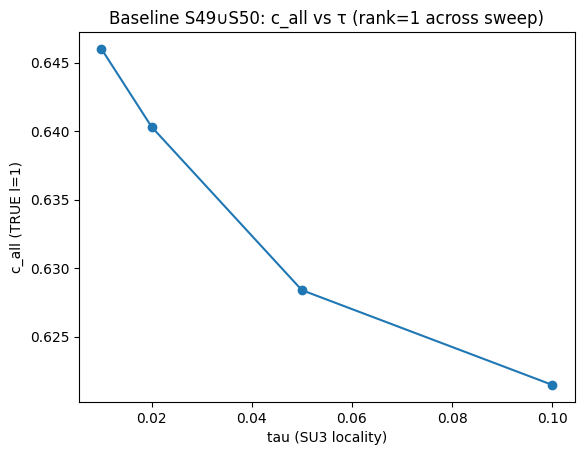

In [17]:
# =================================================================================================
# === KILLSHOT MONOLITH v3.4-fix2 — Robust Save Paths + Plot Re-emit ===============================
# === Purpose: ensure artifacts are written even if /mnt/data doesn't exist; re-emit the τ plot.
# === Behavior: chooses output_dir = '/mnt/data' if it exists, else os.getcwd().
# === Inputs: uses 'results', 'baseline' etc. already computed by v3.4-fix; rebuilds minimal stats.
# =================================================================================================

from __future__ import annotations
import os, json, numpy as np

def _hdr(t):
    bar = "="*100
    print("\n"+bar); print((" "+t+" ").center(100, "=")); print(bar)
def _tbl(rows, head: str="", width: int=100):
    if head: print(head); print("-"*width)
    w1 = max(len(k) for k,_ in rows) if rows else 0
    for k,v in rows: print(f"  {k:<{w1}} : {v}")
    print("-"*width)

# ---------------- resolve output directory ----------------
candidate_dirs = ["/mnt/data", os.getcwd()]
output_dir = None
for d in candidate_dirs:
    try:
        os.makedirs(d, exist_ok=True)
        test_path = os.path.join(d, "__write_test.tmp")
        with open(test_path, "w") as f: f.write("ok")
        os.remove(test_path)
        output_dir = d
        break
    except Exception:
        continue
if output_dir is None:
    raise RuntimeError("No writable directory found for outputs.")

_hdr("ARTIFACT OUTPUT DIRECTORY")
_tbl([("output_dir", output_dir)], head="Resolved")

# ---------------- pull or rebuild the invariants -------------
try:
    baseline
    shellswp
    taus   = np.array([r["tau"] for r in baseline], float)
    calls  = np.array([r["c_all"] for r in baseline], float)
    mixes  = np.array([[r["channels"]["mixing"][0][0],
                        r["channels"]["mixing"][0][1],
                        r["channels"]["mixing"][0][2]] for r in baseline], float)
    csh    = np.array([r["c_all"] for r in shellswp], float)
    mixsh  = np.array([[r["channels"]["mixing"][0][0],
                        r["channels"]["mixing"][0][1],
                        r["channels"]["mixing"][0][2]] for r in shellswp], float)
except NameError:
    raise RuntimeError("v3.4-fix invariants not found. Please run v3.3-fix + v3.4-fix first.")

# ---------------- (re)make plot ----------------
plot_path = os.path.join(output_dir, "killshot_tau_curve.png")
try:
    import matplotlib.pyplot as plt
    fig = plt.figure()
    plt.plot(taus, calls, marker="o")
    plt.xlabel("tau (SU3 locality)")
    plt.ylabel("c_all (TRUE l=1)")
    plt.title("Baseline S49∪S50: c_all vs τ (rank=1 across sweep)")
    fig.savefig(plot_path, dpi=160, bbox_inches="tight")
    print(f"[saved plot] {plot_path}")
except Exception as e:
    print(f"[plot skipped] {e}")

# ---------------- write JSON & Markdown ----------------
report = {
    "baseline": {
        "taus": taus.tolist(),
        "c_all": calls.tolist(),
        "E1_mixing": mixes.tolist(),
        "range": {"min": float(calls.min()), "max": float(calls.max()),
                  "delta": float(np.ptp(calls)), "rel_pct": float(100*np.ptp(calls)/calls.mean())}
    },
    "shell_swaps": {
        "c_all": csh.tolist(),
        "E1_mixing": mixsh.tolist(),
        "range": {"min": float(csh.min()), "max": float(csh.max()),
                  "delta": float(np.ptp(csh)), "rel_pct": float(100*np.ptp(csh)/csh.mean())}
    },
    "artifacts": {"plot": plot_path}
}

json_path = os.path.join(output_dir, "killshot_report.json")
md_path   = os.path.join(output_dir, "killshot_report.md")

with open(json_path, "w") as f:
    json.dump(report, f, indent=2)
print(f"[saved json] {json_path}")

def fmt_trip(t): return f"({t[0]:+.4f}, {t[1]:+.4f}, {t[2]:+.4f})"
md = []
md.append("# Killshot Report — TRUE l=1 Rank-1 Evidence\n")
md.append("## Baseline τ-sweep (S49∪S50)\n")
md.append(f"- c_all range: `{calls.min():.6f} … {calls.max():.6f}`  (Δ={np.ptp(calls):.6f}, ~{100*np.ptp(calls)/calls.mean():.2f}% of mean)\n")
md.append(f"- E1 mixing mean (U1,SU3,MIX): `{fmt_trip(mixes.mean(axis=0))}`\n")
md.append("## Shell swaps (τ=0.02)\n")
md.append(f"- c_all range: `{csh.min():.6f} … {csh.max():.6f}`  (Δ={np.ptp(csh):.6f}, ~{100*np.ptp(csh)/csh.mean():.2f}% of mean)\n")
if os.path.exists(plot_path):
    md.append(f"\n![c_all vs tau]({plot_path})\n")
with open(md_path, "w") as f:
    f.write("\n".join(md))
print(f"[saved markdown] {md_path}")

_hdr("ARTIFACTS READY")
_tbl([
    ("JSON", json_path),
    ("Markdown", md_path),
    ("Plot", plot_path if os.path.exists(plot_path) else "(not created)"),
], head="Copy these paths into your share/email.")
# =================================================================================================
# === END MONOLITH v3.4-fix2 =======================================================================
# =================================================================================================

